**Лабораторная работа №10 “Градиентный бустинг”**

Долматович Алина, 858641

Для выполнения задания используйте набор данных boston из библиотеки sklearn 
https://scikit-learn.org/stable/datasets/index.html#boston-dataset


In [12]:
from sklearn.datasets import load_boston
import pandas as pd
import sklearn
import sklearn.cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pyplot
import numpy as np
from sklearn.linear_model import LinearRegression

Загрузите данные с помощью библиотеки sklearn.

In [2]:
boston = load_boston()
bostonData = pd.DataFrame(boston.data)
bostonData.columns = boston.feature_names
bostonData['PRICE'] = boston.target
print(bostonData.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


Разделите выборку на обучающую (75%) и контрольную (25%).


In [3]:
x = bostonData.drop('PRICE', axis = 1).values
y = bostonData['PRICE'].values
trainX, testX, trainY, testY = sklearn.cross_validation.train_test_split(x, y, test_size=0.25, random_state=5)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

((379, 13), (379,))
((127, 13), (127,))


В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X. Реализуйте ее. Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics.


In [4]:
def boostingPredict(X, regressors, alphas=[1 for i in range(50)]):
    result = [sum([alpha * regressor.predict([x])[0] for regressor, alpha in zip(regressors, alphas)]) for x in X]
    return result

Заведите массив для объектов DecisionTreeRegressor (они будут использоваться в качестве базовых алгоритмов) и для вещественных чисел (коэффициенты перед базовыми алгоритмами).


В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с отклонением истинных значений от предсказанных.


In [5]:
def boosting(x, y, countOfTree, depth, alphas=[1 for i in range(50)]):
    regressors = []
    shift = y.copy()
    for i in range(countOfTree):
        regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
        regressor.fit(x, shift)
        regressors.append(regressor)
        predict = boostingPredict(x, regressors, alphas)
        shift = -(predict-y)
    return regressors

def mse(alpha=1, countOfTree=50, depth=5):
    alphas=[alpha(i) if callable(alpha) else alpha for i in range(countOfTree)]
    regressors = boosting(trainX, trainY, countOfTree, depth, alphas)
    return mean_squared_error(y_true=np.array(testY), y_pred=boostingPredict(np.array(testX), regressors, alphas))**0.5

mse()

6.1027230908259078

Попробуйте всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но на стандартном наборе данных будет всего 50 деревьев, возьмите для начала шаг побольше.


In [6]:
mse(0.9)

5.470486096542726

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Какое получилось качество на контрольной выборке?


In [7]:
def mutableAlpha(i):
    return 0.9 / (1. + i)

mse(mutableAlpha)

5.187553592288821

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций, а также с ростом глубины деревьев. Постройте графики. Какие выводы можно сделать?


In [8]:
def plot(parameters, scores, xlabel):
    pyplot.plot(parameters, scores, marker='.')
    pyplot.xlabel(xlabel)
    pyplot.ylabel('score')
    pyplot.show()    

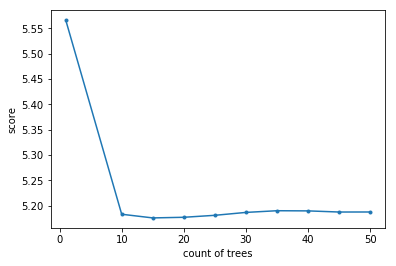

In [9]:
countOfTrees = [1] + range(10, 55, 5)
scores = []
for count in countOfTrees:
    error = mse(mutableAlpha, countOfTree=count, depth=5)
    scores.append(error)
plot(countOfTrees, scores, "count of trees")

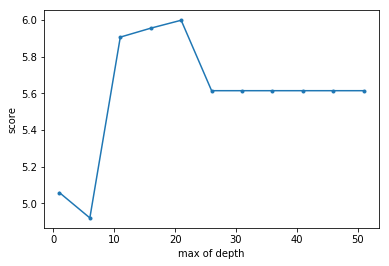

In [10]:
depths = range(1, 55, 5)
scores = []
for depth in depths:
    error = mse(mutableAlpha, countOfTree=50, depth=depth)
    scores.append(error)
plot(depths, scores, "max of depth")

Сравните качество, получаемое с помощью градиентного бустинга с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE.


In [11]:
linearRegression = LinearRegression()
linearRegression.fit(trainX, trainY)
mean_squared_error(y_true=testY, y_pred=linearRegression.predict(testX))**0.5

4.9293108816992275

**Вывод**